# CONTEXTO DO PROBLEMA

A empresa **All in One Place** é uma empresa Outlet Multimarcas, ou seja, ela comercializa produtos de segunda linha de várias marcas a um preço menor, através de um e-commerce.

Em pouco mais de 1 anos de operação, o time de marketing percebeu que alguns clientes da sua base, compram produtos mais caros, com alta frequência e acabam contribuindo com uma parcela significativa do faturamento da empresa.

Baseado nessa percepção, o time de marketing vai lançar um programa de fidelidade para os melhores clientes da base, chamado Insiders. Mas o time não tem um conhecimento avançado em análise de dados para eleger os participantes do programa.

Por esse motivo, o time de marketing requisitou ao time de dados uma seleção de clientes elegíveis ao programa, usando técnicas avançadas de manipulação de dados.

# O PROBLEMA

Você faz parte do time de cientistas de dados da empresa All In One Place, que precisa determinar quem são os clientes elegíveis para participar do Insiders. Em posse dessa lista, o time de Marketing fará uma sequência de ações personalizadas e exclusivas ao grupo, de modo a aumentar o faturamento e a frequência de compra.

Como resultado para esse projeto, é esperado que você entregue uma lista de pessoas elegíveis a participar do programa Insiders, junto com um relatório respondendo às seguintes perguntas:

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
2. Quantos clientes farão parte do grupo?
3. Quais as principais características desses clientes ?
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
7. Quais as condições para uma pessoa ser removida do Insiders ?
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

# ENTENDIMENTO DO PROBLEMA

**Motivação:** 
- Identificar os clientes elegíveis para participar do programa de finalidade (Insiders).

**Causa Raiz do Problema:** 
- Aumentar o faturamento da empresa e a frequência de compra dos clientes.

**Tipo de Problema:** 
- Identificar perfil de clientes que trazem mais retorno financeiro.

**Potênciais Métodos:** 
- Clusterização.

**Entrega da Solução:** 
- WebApp.

# PLANEJAMENTO DA SOLUÇÃO

1. Carregar, explorar os dados usando ferramentas e testes Estatísticos com o objetivo de encontrar inconsistências dos dados e tratar possíveis dados faltantes.

2. Levantar Hipóteses sobre as características de um cliente Insider. Validar ou refutar essas hipóteses através dos dados.

3. Preparar os Dados para que os Algoritmos Estatísticos ou de Machine Learning sejam capazes de aprender a tarefa.

4. Escrever vários algoritmos de Agrupamento ou clusterização.

5. Contabilizar a Performance do Modelo de Machine Learning e transformar em Performance de Negócio.

6. Desenvolver uma API que retorne um “Score de Cluster” para cada cliente, indicando à qual cluster ele pertence.

7. Criar um README sobre como interpretar e usar a sua solução.

8. Escrever um Relatório, respondendo às perguntas de negócio.

# 0.0 IMPORTS

In [125]:
# Manipualtion
import pandas as pd
import numpy as np
import inflection
import re

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pandas_profiling import ProfileReport
from sklearn import decomposition as dd
from sklearn.manifold import TSNE

# ML
from sklearn import cluster
import umap.umap_ as umap
from sklearn.ensemble import RandomForestRegressor

# preparation
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# metric
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Funções Auxiliares

## 0.2 Carregamento de Dados

In [126]:
path = 'C:/Users/Jhonatans/projects/ML/Clusterization/Loyalty-Program-Ecommerce/' # Path project
df = pd.read_csv(path + 'data/Ecommerce.csv', encoding='cp1252') # Load data

df.drop(columns=['Unnamed: 8'], inplace=True) # Drop column Unnamed: 8
df.head() 

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  
0   29-Nov-16       2.55     17850.0  United Kingdom  
1   29-Nov-16       3.39     17850.0  United Kingdom  
2   29-Nov-16       2.75     17850.0  United Kingdom  
3   29-Nov-16       3.39     17850.0  United Kingdom  
4   29-Nov-16       3.39     17850.0  United Kingdom

# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [127]:
df1 = df.copy()

print('Nº Rows: {}'.format(df1.shape[0]))
print('Nº Columns: {}'.format(df1.shape[1]))

Nº Rows: 541909
Nº Columns: 8


## 1.2 Renomeação de Colunas

In [128]:
# Text to snakecase
snakecase = lambda x: inflection.underscore(x)

# New columns with snakecase
df1.columns = list(map(snakecase, df1.columns))
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.3 Tipo de Dados

In [129]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Verificação de Dados Ausentes

In [130]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Tratamento de Dados Ausentes

In [131]:
# missing values
df_missing = df1[df1['customer_id'].isna()]

# create reference
df_buckup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_buckup['customer_id'] = np.arange(19000, 19000+len(df_buckup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_buckup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1.drop(columns=['customer_id_x', 'customer_id_y'], inplace=True)
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Mudança do Tipo de Dados

In [132]:
# invoice_date - str to datetime
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype('int')

## 1.7 Estatística Descritiva

### 1.7.1 Atributos Numéricos

In [133]:
num = df1.select_dtypes(include=['int64', 'float64'])

describe = num.describe().T

describe['skew'] = num.apply(lambda x: x.skew())
describe['kurtosis'] = num.apply(lambda x: x.kurtosis())

describe 

count      mean         std       min   25%   50%    75%  \
quantity    541909.0  9.552250  218.081158 -80995.00  1.00  3.00  10.00   
unit_price  541909.0  4.611114   96.759853 -11062.06  1.25  2.08   4.13   

                max        skew       kurtosis  
quantity    80995.0   -0.264076  119769.160031  
unit_price  38970.0  186.506972   59005.719097

#### 1.7.1.1 Atributos Numéricos - Investigando

1. Qauntity Negativa (pode ser devolução)
2. Preço unitario igual a zero (pode ser promoção?)

### 1.7.2 Atributos Categóricos

#### 1.7.2.1 Atributos Categóricos - Investigando

In [134]:
# Problema: Temos invoice com letras e numeros
# df1['invoice_no'].astype(int)

#### Invoice No

In [135]:
invoice_no_error = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

print('Total letter:', len(invoice_no_error))
print('Total Qauntity negative:', len(invoice_no_error[invoice_no_error['quantity'] < 0]))

Total letter: 9291
Total Qauntity negative: 9288


#### Stock Code

In [136]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]['stock_code'].unique()


# Acão:
## q. Remove stocke_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [137]:
df1.head()

# Ação: Deletar description

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  invoice_date  unit_price         country  customer_id  
0   2016-11-29        2.55  United Kingdom        17850  
1   2016-11-29        3.39  United Kingdom        17850  
2   2016-11-29        2.75  United Kingdom        17850  
3   2016-11-29        3.39  United Kingdom        17850  
4   2016-11-29        3.39  United Kingdom        17850

#### Country

In [138]:
# países unicos
print('Qty Country:', len(df1['country'].unique()))

# Clientes que compram em cada país
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

Qty Country: 38


country  customer_id
36        United Kingdom         7587
14               Germany           95
13                France           90
10                  EIRE           44
31                 Spain           31
3                Belgium           25
33           Switzerland           24
27              Portugal           20
19                 Italy           15
16             Hong Kong           15
12               Finland           12
1                Austria           11
25                Norway           10
24           Netherlands            9
0              Australia            9
37           Unspecified            9
9                Denmark            9
6        Channel Islands            9
7                 Cyprus            8
32                Sweden            8
20                 Japan            8
18                Israel            7
26                Poland            6
5                 Canada            4
34                   USA            4
2                Bahrain            4
15                Greece            4
23                 Malta            2
35  United Arab Emirates            2
8         Czech Republic            1
22             Lithuania            1
11    European Community            1
21               Lebanon            1
28                   RSA            1
29          Saudi Arabia            1
30             Singapore            1
17               Iceland            1
4                 Brazil            1

# 2.0 FILTRAGEM DE DADOS

## 2.1 Atributos Categóricos

In [139]:
df2 = df1.copy()

# Stock Code
df2 = df2[-df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm',
                                   'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns=['description'])

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

## 2.2 Atributos Numéricos

In [140]:
# unit_price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# qunatity
returns = df2.loc[df2['quantity'] < 0, :]
purchases = df2.loc[df2['quantity'] >= 0, :].copy()

# 3.0 FEATURE ENGINEERING

## 3.1 Criação de Feature

In [141]:
# Copy dataframe to section 2
df3 = df2.copy()

# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity',
                   'invoice_date', 'unit_price', 'country'],
                  axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [142]:
# Gross Revenue (Faturamento) quantity * price
purchases['gross_revenue'] = purchases['quantity'] * purchases['unit_price']

# Monetary
df_monetary = purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
print(df_ref.isna().sum(), '\n')

customer_id       0
gross_revenue    91
dtype: int64 



### 3.1.2 Recency - Day from Last Purchase

In [143]:
# Recency - Last day purchase
df_recency = purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
print(df_ref.isna().sum(), '\n')

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64 



### 3.1.3 Quantity of Purchased

In [144]:
# Quantity
df_freq = purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'qty_invoices'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
print(df_ref.isna().sum(), '\n')

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64 



### 3.1.4 Quantity of itemns Purchased

In [145]:
# Quantity
df_freq = purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qty_itemns'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
print(df_ref.isna().sum(), '\n')

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_itemns       91
dtype: int64 



### 3.1.5 Quantity of Products Purchased

In [146]:
# Quantity
df_freq = purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qty_products'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
print(df_ref.isna().sum(), '\n')

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_itemns       91
qty_products     91
dtype: int64 



### 3.1.5 Average Ticket Value

In [147]:
# avg ticket
df_avg_ticket = purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
print(df_ref.isna().sum(), '\n')

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_itemns       91
qty_products     91
avg_ticket       91
dtype: int64 



### 3.1.6 Average Recency Days

In [148]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=['False', 'False'])

df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice_no date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average recency
df_avg_recency_days =  df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_itemns            91
qty_products          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency Purchase

In [149]:
# references
df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
df2_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()

df_aux = purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(
                                                                            max_ = ('invoice_date', 'max'),
                                                                            min_ = ('invoice_date', 'min'),
                                                                            days_= ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                            buy_ = ('invoice_no', 'count')).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_itemns            91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8 Number of Returns

In [150]:
# Number of returns
df_returns = returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_itemns            91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_returns            0
dtype: int64

### 3.1.9 Basket Size - Quantidade de de items por Cesta (Quantity)

In [151]:
df_aux = (purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('quantity', 'sum'))
                                                                       .reset_index())

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_itemns            91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_returns            0
avg_basket_size       91
dtype: int64

### 3.1.10 Unique Basket Size - Quantidade de produtos distintos por compra

In [152]:
df_aux = (purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('quantity', 'nunique'))
                                                                       .reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qty_invoices                91
qty_itemns                  91
qty_products                91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qty_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA

In [159]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qty_invoices              0
qty_itemns                0
qty_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qty_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Análise Univariada

In [114]:
profile = ProfileReport(df4)
profile.to_file('EDA/analysis_v2.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 4.2 Análise Bivariada

<Figure size 1728x864 with 0 Axes>

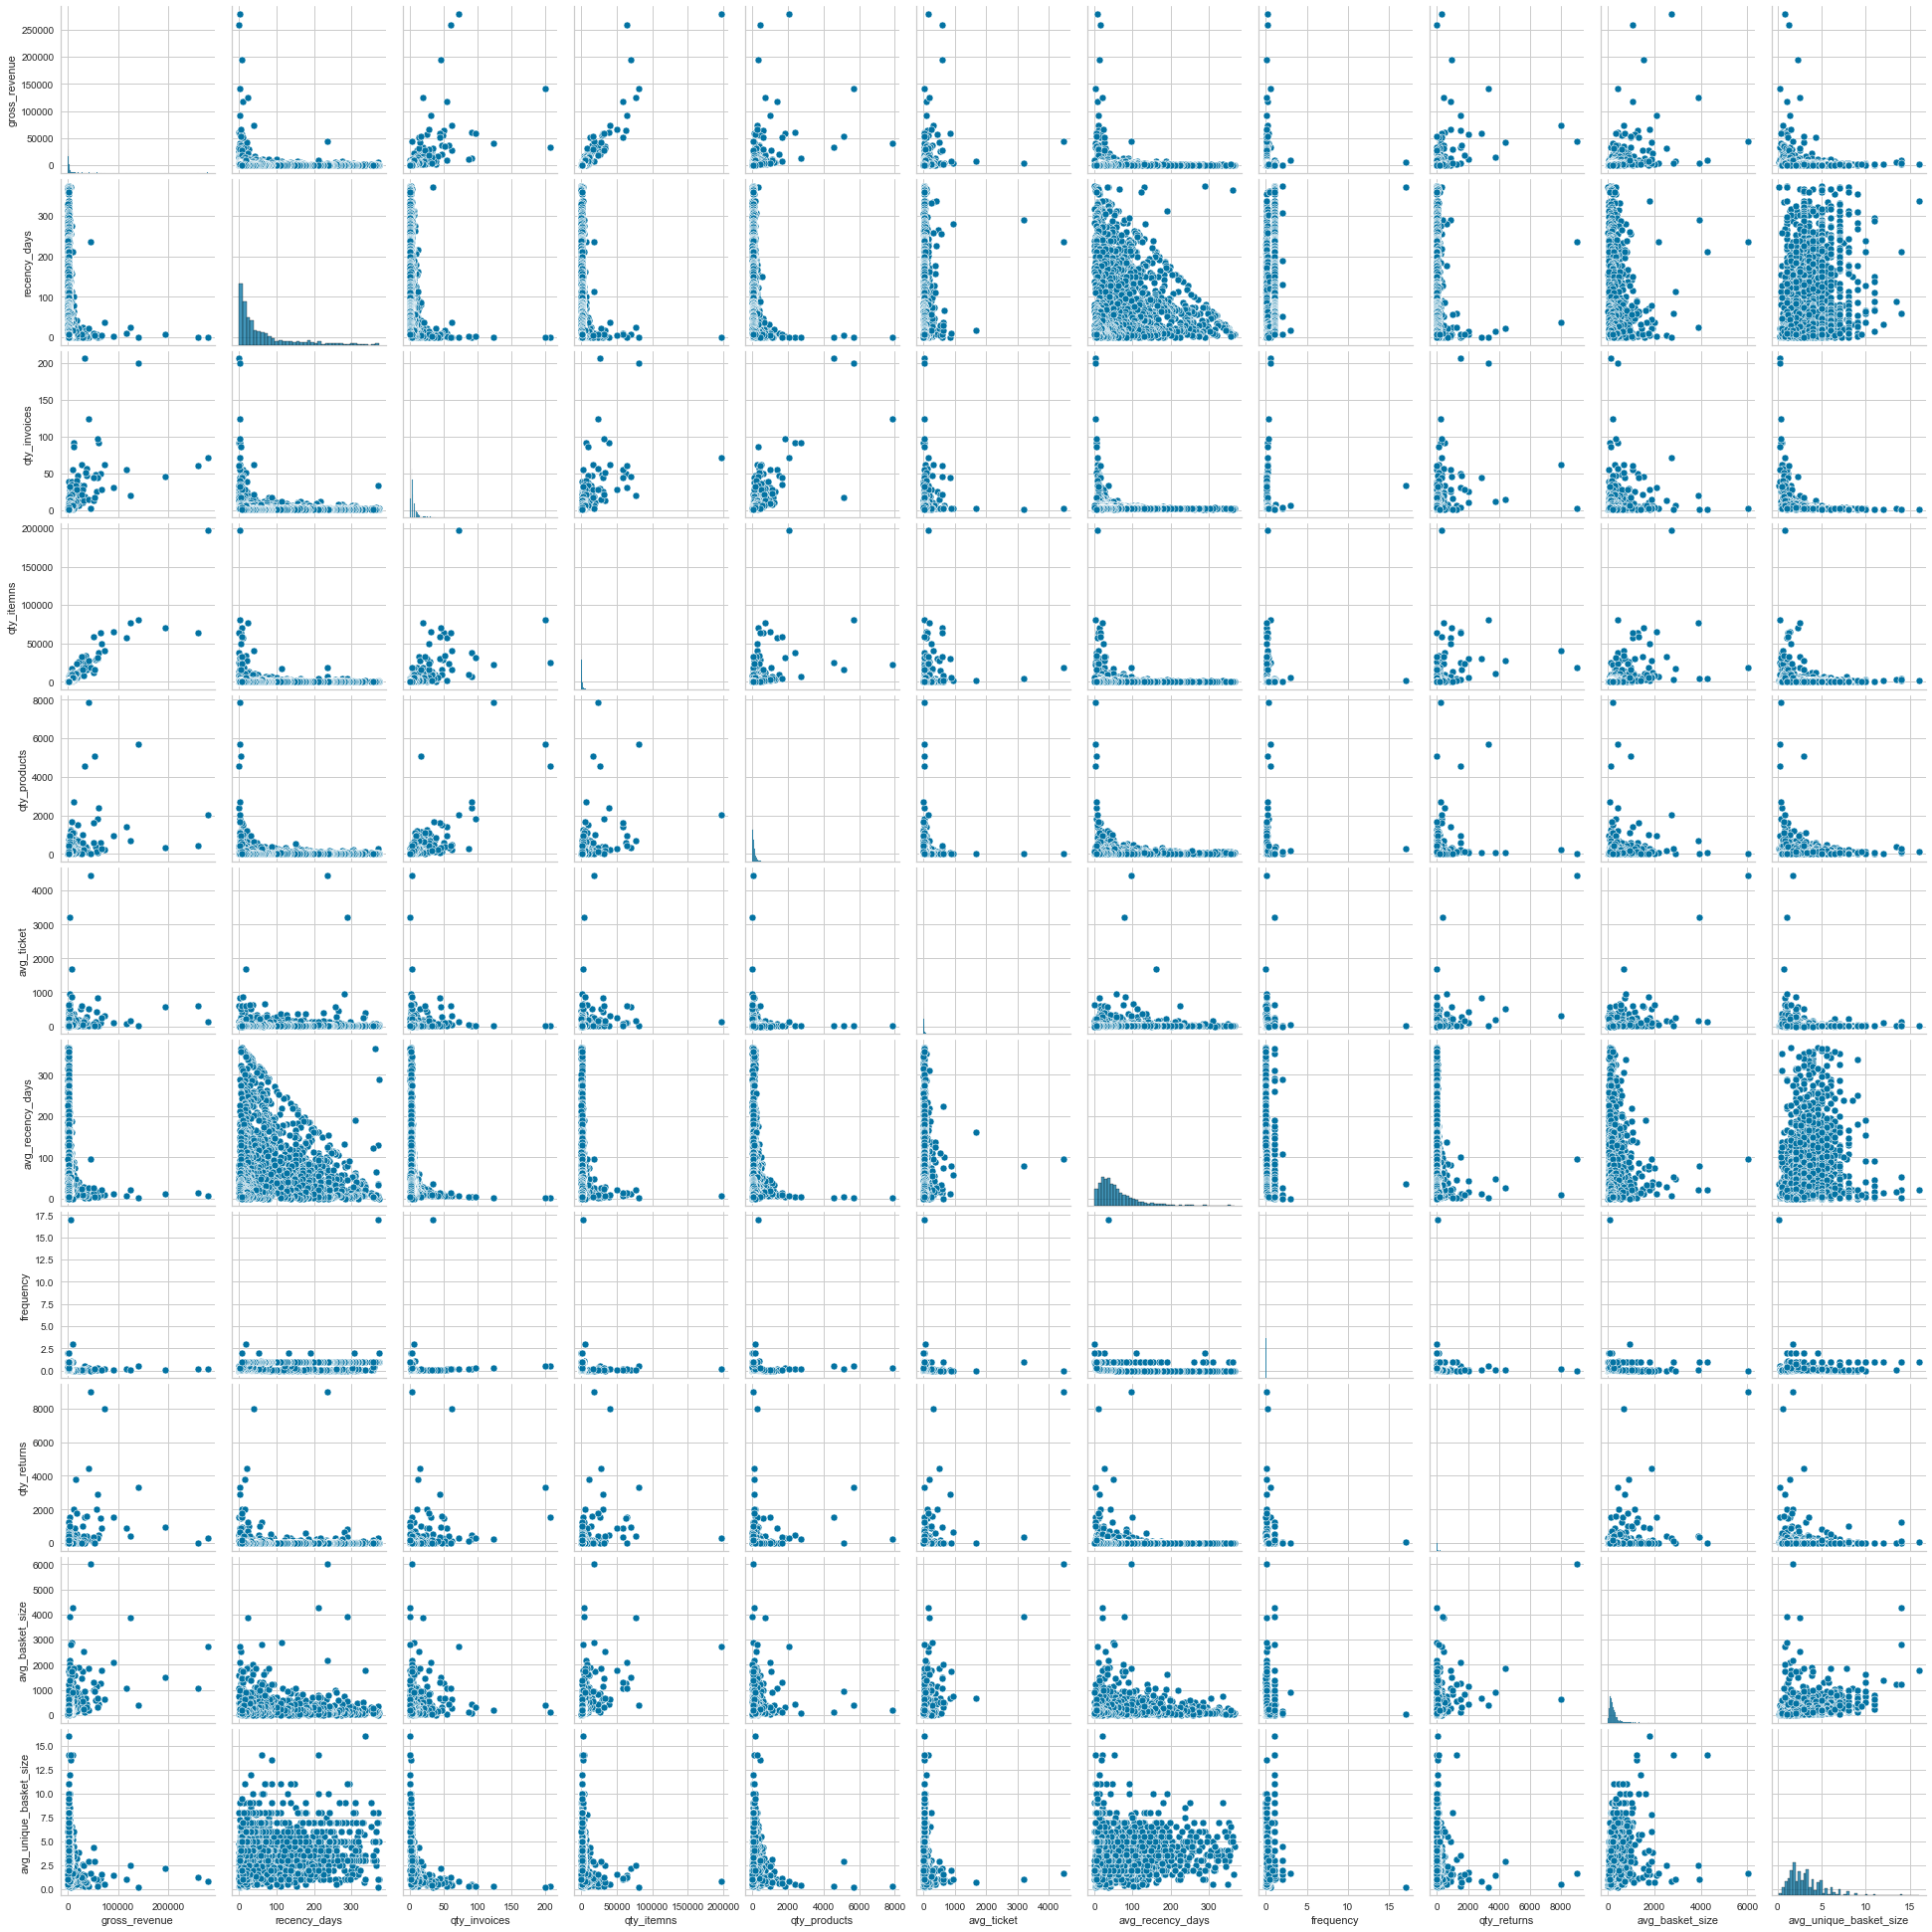

In [154]:
plt.figure(figsize=(24, 12))
sns.pairplot(df4.drop(columns='customer_id'))
plt.grid(False);

**Notes**

1. Frequency has low variance
2. Avg Ticket has low variance

## 4.3 Estudo do Espaço

In [172]:
df43 = df4.drop(columns=['customer_id']).copy()

In [173]:
# processing
mm = MinMaxScaler()

df43['gross_revenue'] =          mm.fit_transform(df43[['gross_revenue']].values)
df43['recency_days'] =           mm.fit_transform(df43[['recency_days']].values)
df43['qty_invoices'] =           mm.fit_transform(df43[['qty_invoices']].values)
df43['qty_itemns'] =             mm.fit_transform(df43[['qty_itemns']].values)
df43['qty_products'] =           mm.fit_transform(df43[['qty_products']].values)
df43['avg_ticket'] =             mm.fit_transform(df43[['avg_ticket']].values)
df43['avg_recency_days'] =       mm.fit_transform(df43[['avg_recency_days']].values)
df43['frequency'] =              mm.fit_transform(df43[['frequency']].values)
df43['qty_returns'] =            mm.fit_transform(df43[['qty_returns']].values)
df43['avg_basket_size'] =        mm.fit_transform(df43[['avg_basket_size']].values)
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']].values)

x = df43.copy()

### 4.3.1 PCA

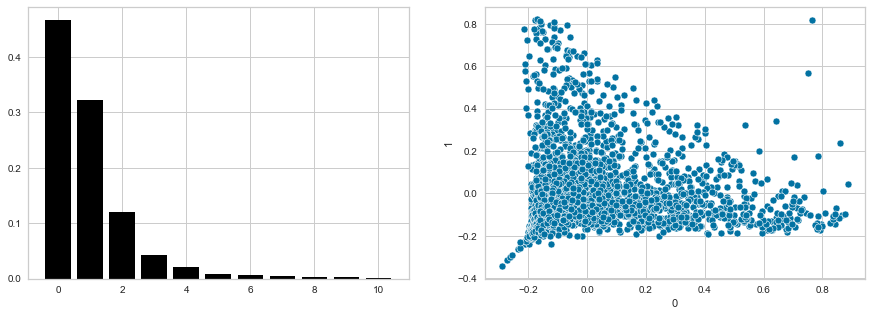

In [174]:
pca = dd.PCA(n_components=x.shape[1])

principal_component = pca.fit_transform(x)

# plot explaneid variable
features = range(pca.n_components_)

# pca component
df_pca = pd.DataFrame(principal_component)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(features, pca.explained_variance_ratio_, color='black')

plt.subplot(1, 2, 2)
sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2 UMAP

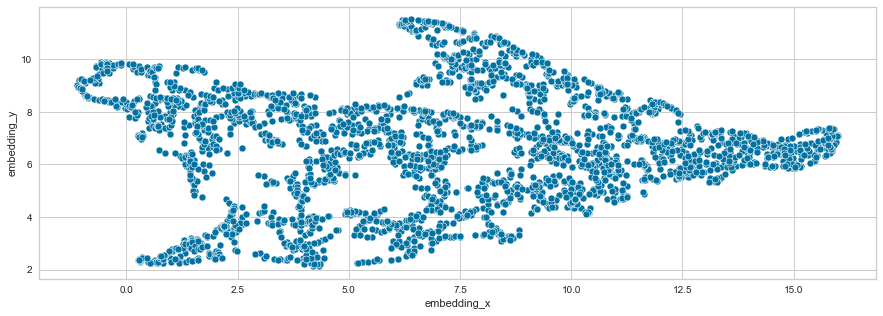

In [175]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(x)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plt UMAP
plt.figure(figsize=(15, 5))
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca);

### 4.3.3 t-SNE

c:\users\jhonatans\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jhonatans\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


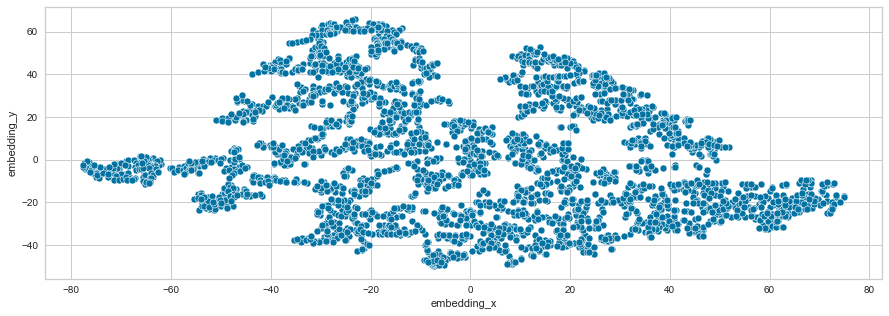

In [176]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(x)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plt UMAP
plt.figure(figsize=(15, 5))
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca);

### 4.3.3 Tree-Based Embedding

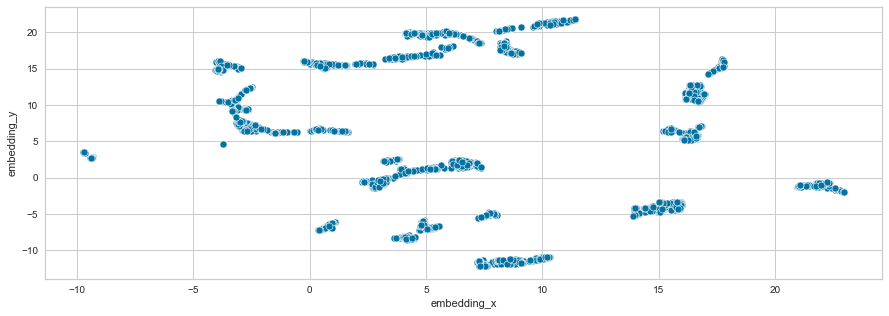

In [177]:
# training dataset
x = df4.drop(columns=['customer_id', 'gross_revenue'])
y = df4['gross_revenue']

# model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# model_training
rf_model.fit(x, y)

# dataset leaf
df_leaf = pd.DataFrame(rf_model.apply(x))

# plot 
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plt UMAP
plt.figure(figsize=(15, 5))
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca);

# 5.0 PREPARAÇÃO DE DADOS

In [184]:
df5 = df4.copy()
ss = StandardScaler()

# gross_revenue
df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']].values)

# recency_days
df5['recency_days'] = ss.fit_transform(df5[['recency_days']].values)

# qty_itemns
df5['qty_itemns'] = ss.fit_transform(df5[['qty_itemns']].values)

# qty_products
df5['qty_products'] = ss.fit_transform(df5[['qty_products']].values)

# avg_ticket
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']].values)

# avg_recency_days
df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']].values)

# frequency
df5['frequency'] = ss.fit_transform(df5[['frequency']].values)

# qty_invoices
df5['qty_invoices'] = ss.fit_transform(df5[['qty_invoices']].values)

# avg_basket_size
df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']].values)

# avg_unique_basket_size
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']].values)

# qty_returns
df5['qty_returns'] = ss.fit_transform(df5[['qty_returns']].values)

# 6.0 SELEÇÃO DE FEATURE

In [186]:
df6 = df5.copy()

# 7.0 AJUSTE DE HIPERPARAMETROS

In [187]:
x = df6.drop(columns=['customer_id'])

In [188]:
x.head()

gross_revenue  recency_days  qty_invoices  qty_itemns  qty_products  \
0       0.266212      3.957548      3.192723    0.026453      0.645586   
1       0.053199     -0.106875      0.369863   -0.033677      0.178725   
2       0.395894     -0.801428      1.047349    0.604084      0.404745   
3      -0.172220      0.394747     -0.081794   -0.200392     -0.351126   
4      -0.179350      3.455926     -0.307623   -0.263327     -0.443757   

   avg_ticket  avg_recency_days  frequency  qty_returns  avg_basket_size  \
0   -0.124189         -0.500863  41.372275     0.018074        -0.652758   
1   -0.117898         -0.630795  -0.209556     0.000394        -0.288215   
2   -0.034237         -0.694777  -0.180104     0.053432         0.348595   
3    0.007295          0.399475  -0.234989    -0.123361        -0.523006   
4    2.167196         -0.924521  -0.099624    -0.045572        -0.738382   

   avg_unique_basket_size  
0               -1.605007  
1               -1.034600  
2               -0.828540  
3               -0.828540  
4               -1.337629

## 7.1 Within-Culster Sum of Square (WSS)

c:\users\jhonatans\appdata\local\programs\python\python39\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\users\jhonatans\appdata\local\programs\python\python39\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


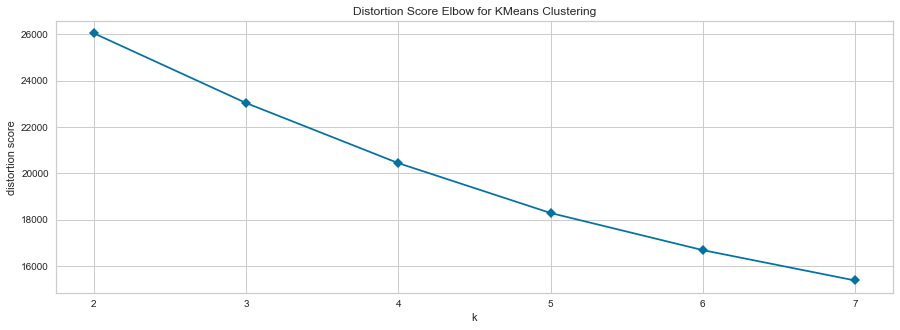

In [189]:
# number of cluesters
clusters = [2, 3, 4, 5, 6, 7]

# plot metric WSS
plt.figure(figsize=(15, 5))
kmeans = KElbowVisualizer(cluster.KMeans(), k=clusters, timings=False)
kmeans.fit(x)
kmeans.show();

## 7.2 Silhouette Score

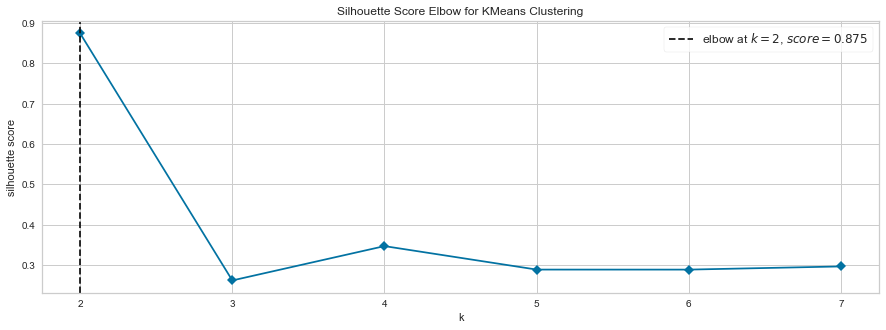

In [190]:
plt.figure(figsize=(15, 5))
kmeans = KElbowVisualizer(cluster.KMeans(), k=clusters, metric='silhouette', timings=False, figsize=(15, 5))
kmeans.fit(x)
kmeans.show();

### 7.2.1 Análise de Silhouette

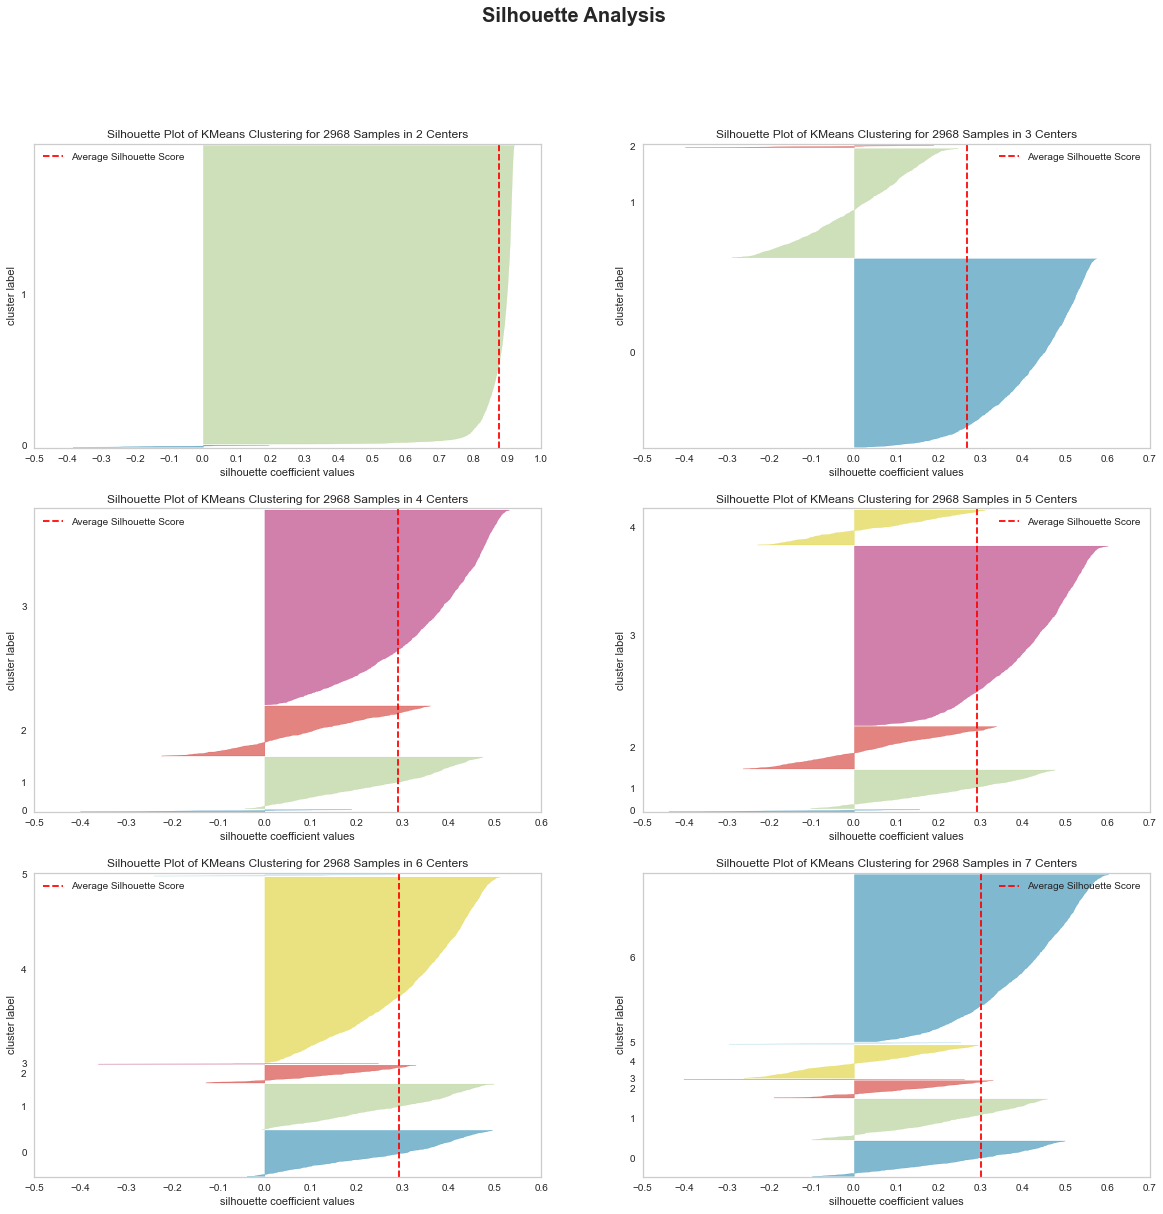

In [191]:
fig, ax = plt.subplots(3, 2, figsize=(20, 19))

for k in clusters:
    
    km = cluster.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].grid(False)
    visualizer.fit(x)
    visualizer.finalize()
    
plt.suptitle('Silhouette Analysis', fontweight="bold", size=20);

# 8.0 TREINAMENTO DO MODELO

## 8.1 K-Means

In [37]:
# model definition
k = 3
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(x)

# clustering
labels = kmeans.labels_

## 8.2 Validação de Cluster

### 8.2.1 WSS (Within-cluster Sum of Square)

In [38]:
print('WSS:', kmeans.inertia_)

WSS: 9419.056420430217


### 8.2.2  Silhouete Score

In [39]:
print('Silhouete', silhouette_score(x, labels, metric='euclidean'))

Silhouete 0.5888965255329137


# 9.0 ANÁLISE DE CLUSTER

In [40]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Inspeção Visual

c:\users\jhonatans\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


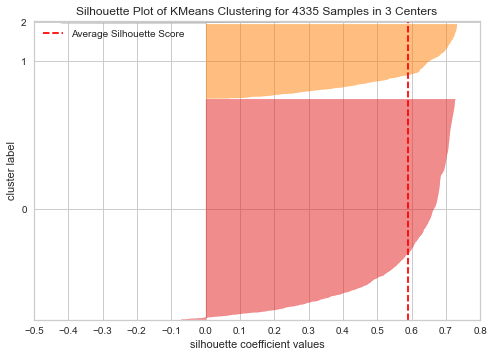

In [41]:
visualizer = SilhouetteVisualizer(kmeans, color='ywllowbrick')
visualizer.fit(x)
visualizer.finalize()

## 9.2 2d plot

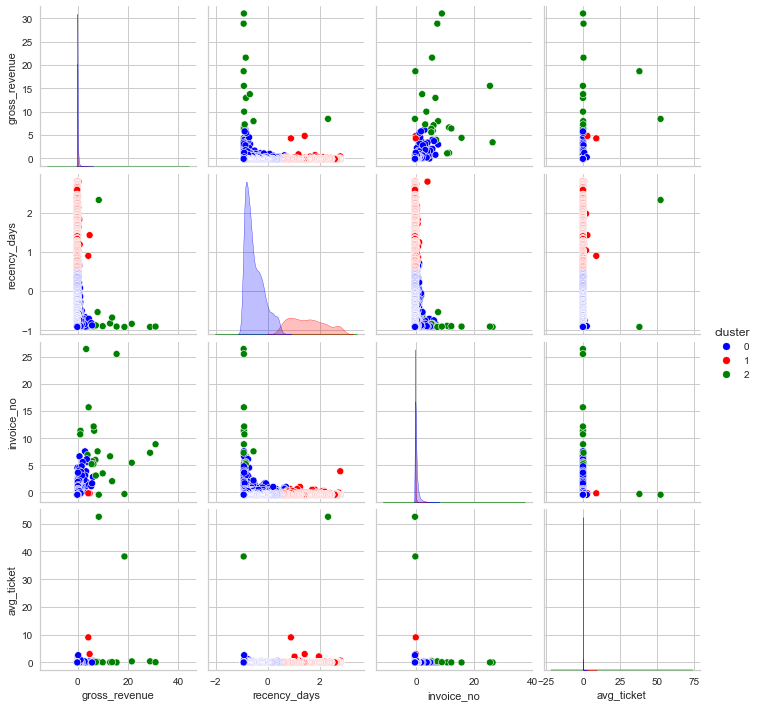

In [44]:
df_viz = df9.drop(columns=['customer_id'])
sns.pairplot(df_viz, hue='cluster', palette=['blue', 'red', 'green'])

## 9.3 UMAP

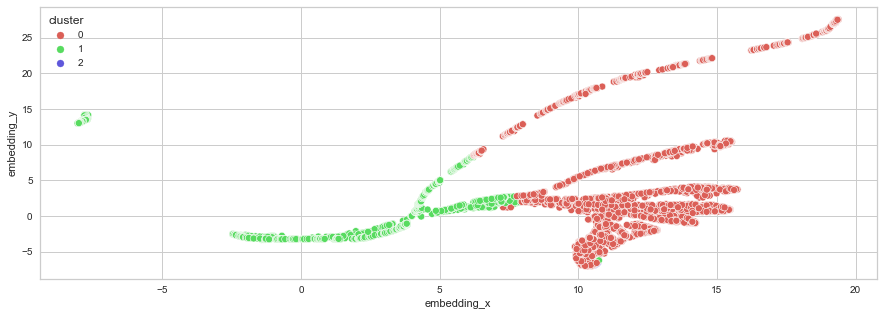

In [49]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(x)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plt UMAP
plt.figure(figsize=(15, 5))
sns.scatterplot(x='embedding_x', y='embedding_y',
               hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
               data=df_viz);

In [153]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2 Perfil de Cluster

In [151]:
# NUmber of cluster
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# avg invoice no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# abg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

cluster  customer_id  perc_customer  gross_revenue  recency_days  \
0        0         3226      74.417532      -0.015115     -0.513465   
1        1         1087      25.074971      -0.164442      1.538499   
2        2           22       0.507497      10.341286     -0.723204   

   invoice_no  avg_ticket  
0    0.060384   -0.025668  
1   -0.350146   -0.008663  
2    8.445882    4.191919

# 10.0 DEPLOY MODELO